# Experiment with MobileNet

Import packages

In [1]:
import os
import cv2
import random

from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

2025-06-10 17:19:35.791914: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-10 17:19:35.808433: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-10 17:19:35.808461: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-10 17:19:35.818274: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-10 17:19:36.714946: W tensorflow/compiler/tf

## Define plotting function for training loss and set parameters

In [2]:
import matplotlib.pyplot as plt

def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2, ax3, ax4 = axs
    else:
        f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    
    ax3.plot(history.history['precision'], label='train precision'  + exp_name)
    ax3.plot(history.history['val_precision'], label='val precision'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax3.set_title('Precision')
    ax3.legend()
    
    ax4.plot(history.history['recall'], label='train recall'  + exp_name)
    ax4.plot(history.history['val_recall'], label='val recall'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax4.set_title('Recall')
    ax4.legend()
    return (ax1, ax2, ax3, ax4)

In [3]:
train_dir = "../raw_data/classification/train"
val_dir = "../raw_data/classification/valid"
test_dir = "../raw_data/classification/test"

image_size = 224
classes = ["0", "1"]

## Original load data and resize

In [4]:
# def load_and_resize_data(path, classes):
#     dataset = []
#     for label in classes:
#         class_path = os.path.join(path, label)
#         label_index = classes.index(label)
        
#         for file in os.listdir(class_path):
#             file_full_path = os.path.join(class_path, file)
#             img = cv2.imread(file_full_path)

#             if img is None:
#                 continue

#             img = cv2.resize(img, (image_size, image_size))
#             dataset.append([img, label_index])
    
#     return dataset

In [5]:
# train_dataset = load_and_resize_data(train_dir, classes)
# val_dataset = load_and_resize_data(val_dir, classes)
# test_dataset = load_and_resize_data(test_dir, classes)

In [6]:
# random.shuffle(train_dataset)
# random.shuffle(test_dataset)
# random.shuffle(val_dataset)

Define X_train, y_train, etc.

In [7]:
# def split_img_label(dataset):
#     X = []
#     y = []
    
#     for img, label in train_dataset:
#         X.append(img)
#         y.append(label)
    
#     X = np.array(X)/255
#     y = np.array(y)
        
#     return X, y

In [8]:
# X_train, y_train = split_img_label(train_dataset)
# X_val, y_val = split_img_label(val_dataset)
# X_test, y_test = split_img_label(test_dataset)

Extra shuffled version of the data

In [9]:
# import math

# mixed_dataset = train_dataset + test_dataset + val_dataset
# random.shuffle(mixed_dataset)

# train_len = int(0.6*len(mixed_dataset))
# val_len = int(0.2*len(mixed_dataset))
# test_len = int(0.2*len(mixed_dataset))

# train_dataset2 = mixed_dataset[0:train_len]
# val_dataset2 = mixed_dataset[train_len:train_len+val_len]
# test_dataset2 = mixed_dataset[train_len+val_len:train_len+val_len+test_len]

# X_train2, y_train2 = split_img_label(train_dataset2)
# X_val2, y_val2 = split_img_label(val_dataset2)
# X_test2, y_test2 = split_img_label(test_dataset2)

# New loading method

In [10]:
def load_data(data_path, classes):
    imgs = []
    labels = []
    for cl in classes:
        images_path = [elt for elt in os.listdir(os.path.join(data_path, cl)) if not elt.find(':Zone.Identifier')>0 and (elt.find('.jpg')>0 or elt.find('.png')>0)]
        for img in images_path:
            path = os.path.join(data_path, cl, img)
            if os.path.exists(path):
                image = Image.open(path)
                image = image.resize((image_size, image_size))
                imgs.append(np.array(image))
                labels.append(int(cl))

    X = np.array(imgs)/255
    y = np.array(labels)

    # Finally we shuffle:
    p = np.random.permutation(len(X))
    X, y = X[p], y[p]

    #first_split = int(len(imgs) /6.)
    #second_split = first_split + int(len(imgs) * 0.2)
    #X_test, X_val, X_train = X[:first_split], X[first_split:second_split], X[second_split:]
    #y_test, y_val, y_train = y[:first_split], y[first_split:second_split], y[second_split:]

    #return X_train, y_train, X_val, y_val, X_test, y_test
    return X, y

In [11]:
X_train, y_train = load_data(train_dir, classes)
X_val, y_val = load_data(val_dir, classes)
X_test, y_test = load_data(test_dir, classes)

## Visualize an image

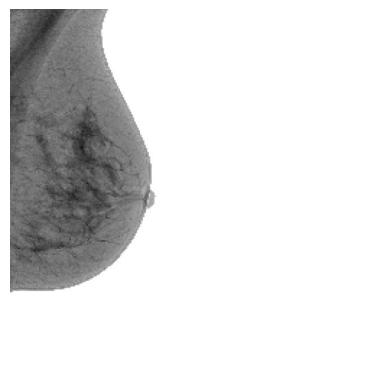

In [12]:
sample_image_path = train_dir + "/0/105_1232990271_png.rf.0d15468a4bec2ad2147f0616b6821681.jpg"
sample_image = Image.open(sample_image_path).resize((640, 640))
plt.imshow(sample_image)
plt.axis('off')  # Turn off the axes for a cleaner visualization
plt.show()

## Setup model: InceptionV3

In [13]:
from keras.applications.vgg16 import VGG16
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.inception_v3 import InceptionV3

def load_model():

    model = InceptionV3(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=((image_size, image_size, 3)),
    pooling=None
    )

    return model

In [14]:
#model = load_model()
#model.summary()

In [15]:
def set_nontrainable_layers(model):

    model.trainable = False

    return model

In [16]:
from keras import layers, models

def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''
    base_model = load_model()
    base_model = set_nontrainable_layers(base_model)
    flattening_layer = layers.Flatten()
    dense_layer = layers.Dense(64, activation='relu')
    prediction_layer = layers.Dense(1, activation='sigmoid')

    model = tf.keras.Sequential([
      base_model,
      flattening_layer,
      dense_layer,
      prediction_layer
    ])
    return model

In [17]:
#add_last_layers(model).summary()

In [18]:
from keras import optimizers

def build_model():
    model = load_model()
    model = add_last_layers(model)
    model.compile(loss="binary_crossentropy", 
                  optimizer = optimizers.Adam(learning_rate=1e-3), 
                  metrics = ["accuracy", "precision", "recall"])

    return model

In [19]:
build_model().summary()

2025-06-10 17:19:56.748783: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-10 17:19:56.772198: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-10 17:19:56.772251: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-10 17:19:56.774689: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-10 17:19:56.774766: I external/local_xla/xla/stream_executor

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,276,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,079,713 (95.67 MB)

 Trainable params: 3,276,929 (12.50 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [26]:
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler

model = build_model()

#Train model:
es = EarlyStopping(monitor = "val_accuracy", patience = 5, restore_best_weights=True)

# This is a sample of a scheduler I used in the past
def lr_scheduler(epoch, lr):
    decay_rate = 0.95
    decay_step = 1
    if epoch % decay_step == 0 and epoch:
        return lr * pow(decay_rate, np.floor(epoch / 2*decay_step))
    return lr

with tf.device("/GPU:0"):
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        batch_size=64,
        epochs=200,
        callbacks=[es, LearningRateScheduler(lr_scheduler, verbose=1)],
        verbose=1)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 281ms/step - accuracy: 0.5784 - loss: 5.7305 - precision: 0.3692 - recall: 0.3999 - val_accuracy: 0.5363 - val_loss: 1.5968 - val_precision: 0.3631 - val_recall: 0.5022 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.6068 - loss: 1.2995 - precision: 0.4428 - recall: 0.4790 - val_accuracy: 0.6667 - val_loss: 1.0489 - val_precision: 0.5625 - val_recall: 0.0396 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0009500000451225787.
Epoch 3/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7071 - loss: 0.6115 - precision: 0.6022 - recall: 0.4886 - val_accuracy: 0.6415 - val_loss: 0.7640 - val_precision: 0.4503 - val_recall: 0.2996 - learning_rate: 9.5000e-04

Epoch 4: LearningRateScheduler setting learning rat

In [27]:
res = model.evaluate(X_test, y_test)
res

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.6322 - loss: 1.0397 - precision: 0.5698 - recall: 0.1586


[1.0609506368637085, 0.636904776096344, 0.6071428656578064, 0.1328125]

(<Axes: title={'center': 'loss'}>,
 <Axes: title={'center': 'Accuracy'}>,
 <Axes: title={'center': 'Precision'}>,
 <Axes: title={'center': 'Recall'}>)

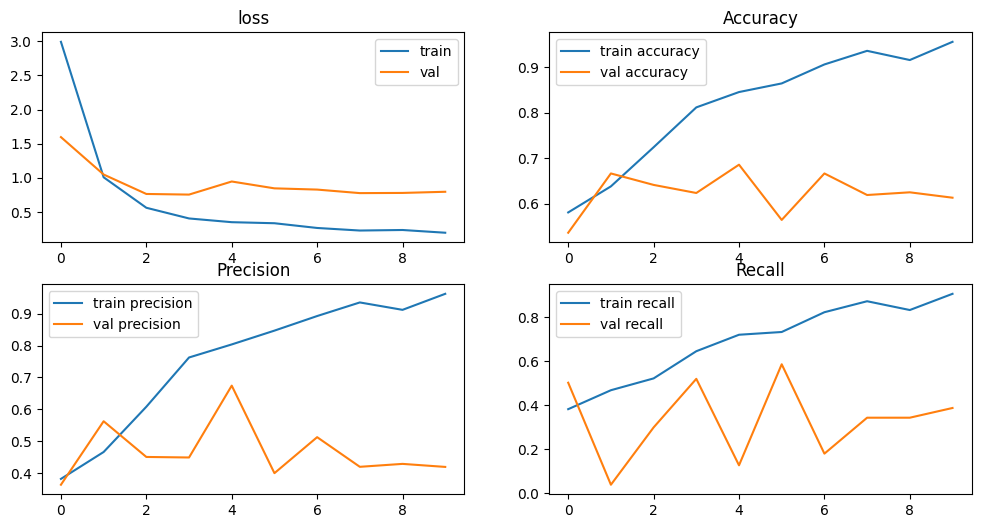

In [28]:
plot_history(history)

In [31]:
for index in range(15):
    if model.predict(X_test[index].reshape(-1,image_size,image_size,3))[0][0] > 0.6:
        print(1, y_test[index])
    else:
        print(0, y_test[index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
0 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
0 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
0 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
0 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
0 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
0 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
0 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
0 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
0 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
0 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
0 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
0 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
0 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
0 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1 1


In [30]:
from tensorflow.keras.models import save_model

save_model(model, "inceptionv3_mammography_model.keras")

## Retrain

In [23]:
#from keras.callbacks import EarlyStopping

#model2 = build_model()

#Train model:
#es = EarlyStopping(patience = 10, restore_best_weights=True)

#with tf.device("/GPU:0"):
#    history = model2.fit(
#        X_train2,
#        y_train2,
#        validation_data=(X_val2, y_val2),
#        batch_size=128,
#        epochs=110,
#        callbacks=[es],
#        verbose=1)

In [24]:
#res2 = model2.evaluate(X_test2, y_test2)
#res2

In [25]:
#plot_history(history)

## Compare with other dataset

In [6]:
test2_dir = "../raw_data/classification/KAU-BCMD"

In [7]:
X_test2, y_test2 = load_data(test2_dir, classes)

In [28]:
res2 = model.evaluate(X_test2, y_test2)
res2

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9366 - loss: 0.3615 - precision: 0.0000e+00 - recall: 0.0000e+00


[0.37119030952453613, 0.9316239356994629, 0.0, 0.0]

In [29]:
for index in range(20):
    if model.predict(X_test2[index].reshape(-1,image_size,image_size,3))[0][0] > 0.5:
        print(1, y_test2[index])
    else:
        print(0, y_test2[index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step
0 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
0 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
0 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
0 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
0 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
0 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
0 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
0 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
0 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
0 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
0 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
0 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
0 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
0 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
0 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
0 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
0 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
0 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
0 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
0 0


## Other model

In [12]:
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Recall
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [20]:
# Initialize a Sequential model
model = Sequential()

# First convolutional layer with 100 filters of size 3x3, using ReLU activation
# The input shape is set to 224x224 pixels with 3 color channels (RGB)
model.add(Conv2D(100, (3, 3), activation="relu", input_shape=(224, 224, 3)))

# First max pooling layer to reduce spatial dimensions (down-sampling by half)
model.add(MaxPooling2D(2, 2))

# Second convolutional layer with 100 filters of size 3x3, using ReLU activation
model.add(Conv2D(100, (3, 3), activation="relu"))

# Second max pooling layer for further down-sampling
model.add(MaxPooling2D(2, 2))

# Third convolutional layer with 64 filters of size 3x3, using ReLU activation
model.add(Conv2D(64, (3, 3), activation="relu"))

# Fourth convolutional layer, also with 64 filters of size 3x3, using ReLU activation
model.add(Conv2D(64, (3, 3), activation="relu"))

# Third max pooling layer to further reduce spatial dimensions
model.add(MaxPooling2D(2, 2))

# Flatten the feature maps into a 1D vector for the fully connected layers
model.add(Flatten())

# First fully connected layer with 64 units and ReLU activation
model.add(Dense(64, activation="relu"))

# Dropout layer to randomly set 20% of the inputs to zero, preventing overfitting
model.add(Dropout(.2))

# Second fully connected layer with 32 units and ReLU activation
model.add(Dense(32, activation="relu"))

# Dropout layer to randomly set 30% of the inputs to zero, for further regularization
model.add(Dropout(.3))

# Third fully connected layer with 32 units and ReLU activation
model.add(Dense(32, activation="relu"))

# Output layer with 1 unit and sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer and binary cross-entropy loss for binary classification
# Use accuracy as the evaluation metric
model.compile(optimizer = "adam", loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall'])

# Display the model summary for an overview of the layers and parameters
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 100)  │         2,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 100)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 109, 109, 100)  │        90,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 52, 52, 64)     │        57,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │     2,560,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,750,725 (10.49 MB)

 Trainable params: 2,750,725 (10.49 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler

#Train model:
es = EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights=True)


# This is a sample of a scheduler I used in the past
def lr_scheduler(epoch, lr):
    decay_rate = 0.95
    decay_step = 1
    if epoch % decay_step == 0 and epoch:
        return lr * pow(decay_rate, np.floor(epoch / decay_step))
    return lr


with tf.device("/GPU:0"):
    history = model.fit(X_train, 
                        y_train, 
                        validation_data=(X_val, y_val), 
                        batch_size=64,
                        epochs=200,
                        callbacks=[es, LearningRateScheduler(lr_scheduler, verbose=1)],
                        verbose=1)


Epoch 1: LearningRateScheduler setting learning rate to 0.00034867844078689814.
Epoch 1/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.6540 - loss: 0.6299 - precision: 0.4966 - recall: 0.0725 - val_accuracy: 0.6726 - val_loss: 0.6284 - val_precision: 0.5385 - val_recall: 0.1850 - learning_rate: 3.4868e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00033124451874755323.
Epoch 2/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.6879 - loss: 0.6098 - precision: 0.6042 - recall: 0.1515 - val_accuracy: 0.6593 - val_loss: 0.6298 - val_precision: 0.4860 - val_recall: 0.2291 - learning_rate: 3.3124e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0002989481781696668.
Epoch 3/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.6667 - loss: 0.6159 - precision: 0.6293 - recall: 0.1415 - val_accuracy: 0.6726 - val_loss: 0.6193 - val_precision: 0.5366 - val_recall: 0.1938 - learning_rate: 2.9895e-04

Epoch 4: LearningRateScheduler setting lear

In [25]:
res3 = model.evaluate(X_test, y_test)
res3

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6468 - loss: 0.6550 - precision: 0.6337 - recall: 0.2108


[0.6523407101631165, 0.636904776096344, 0.5625, 0.2109375]

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

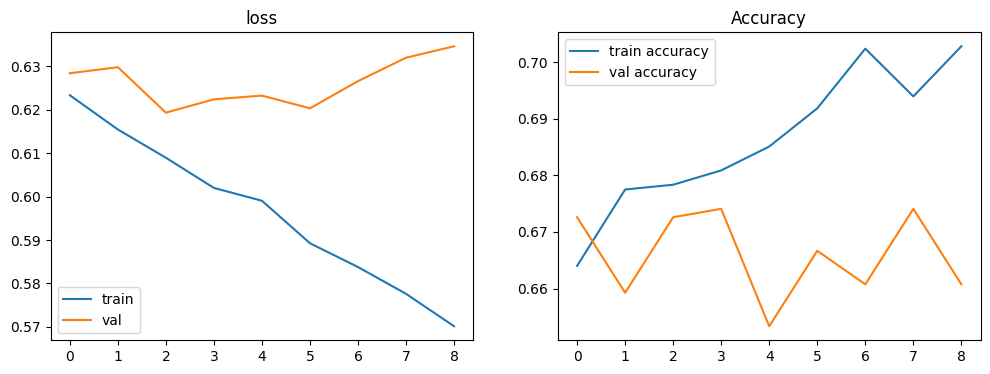

In [26]:
plot_history(history)

In [13]:
res4 = model.evaluate(X_test2, y_test2)
res4

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9456 - loss: 0.4058 - precision: 0.0000e+00 - recall: 0.0000e+00


[0.41266682744026184, 0.9376571178436279, 0.0, 0.0]